**Credit Card Fraud Detection**

The objective is to detect credit card fraud in a highly imbalanced dataset. Among others, Logistic Regression and Support Vector Classifier are used for classification. SMOTE and other over- and undersampling methods are explored to deal with unbalanced data. PCA and t-SNE are used to visualize and simplify the high dimensional data.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import StandardScaler 
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.svm import LinearSVC

**Overview**

In [2]:
data = pd.read_csv("creditcard.csv")
data.shape

(284807, 31)

In [3]:
# all features V1 to V28 are results of a PCA dimensionality reduction for confidencial reasons
# time are the seconds bewtween first and a given transaction
# 1 flags fraud, 0 flags no fraud
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# no missing entries
data.isnull().sum().sum()

0

In [5]:
# all columns are numeric
data.dtypes.value_counts()

float64    30
int64       1
dtype: int64

In [6]:
# highly unbalanced dataset
# Can cause overfitting: every classification is no fraud
no_fraud_cases = len(data[data["Class"]==0])
print("{}% of all transactions are labeled as fraud.".format(round(1-(no_fraud_cases/data.shape[0]),6)*100))

0.1727% of all transactions are labeled as fraud.


In [7]:
#data comes from a timespan of 48 hours
max(data["Time"])/3600

47.99777777777778

In [8]:
#overview
fraud = data[data["Class"]==1]
no_fraud = data[data["Class"]==0]

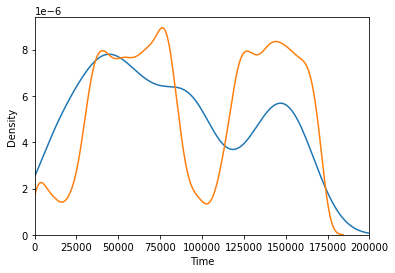

In [9]:
#fraudulant activities seem to rise with normal activity 
ax = plt.subplot()
sns.kdeplot(fraud["Time"])
sns.kdeplot(no_fraud["Time"])
ax.set_xlim(0,200000)
plt.show()
#blau -> no_fraud
#orange -> fraud

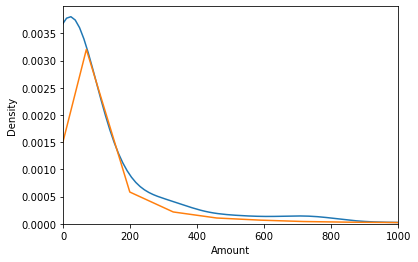

In [10]:
#Different frequencys of Fruad and no fraud for amounts smaller than ~100 
ax = plt.subplot()
sns.kdeplot(fraud["Amount"])
sns.kdeplot(no_fraud["Amount"])
ax.set_xlim(0,1000)
plt.show()

In [11]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [12]:
no_fraud.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [13]:
# Time and Amount are not scaled. Results get better when all features are scaled.
data["time_scaled"] = RobustScaler().fit_transform(data.Time.values.reshape(-1,1))
data["amount_scaled"] = RobustScaler().fit_transform(data.Amount.values.reshape(-1,1))
data.drop(["Time","Amount"],axis = 1,inplace=True)
fraud = data[data["Class"]==1].reset_index(drop=True)
no_fraud = data[data["Class"]==0].reset_index(drop=True)

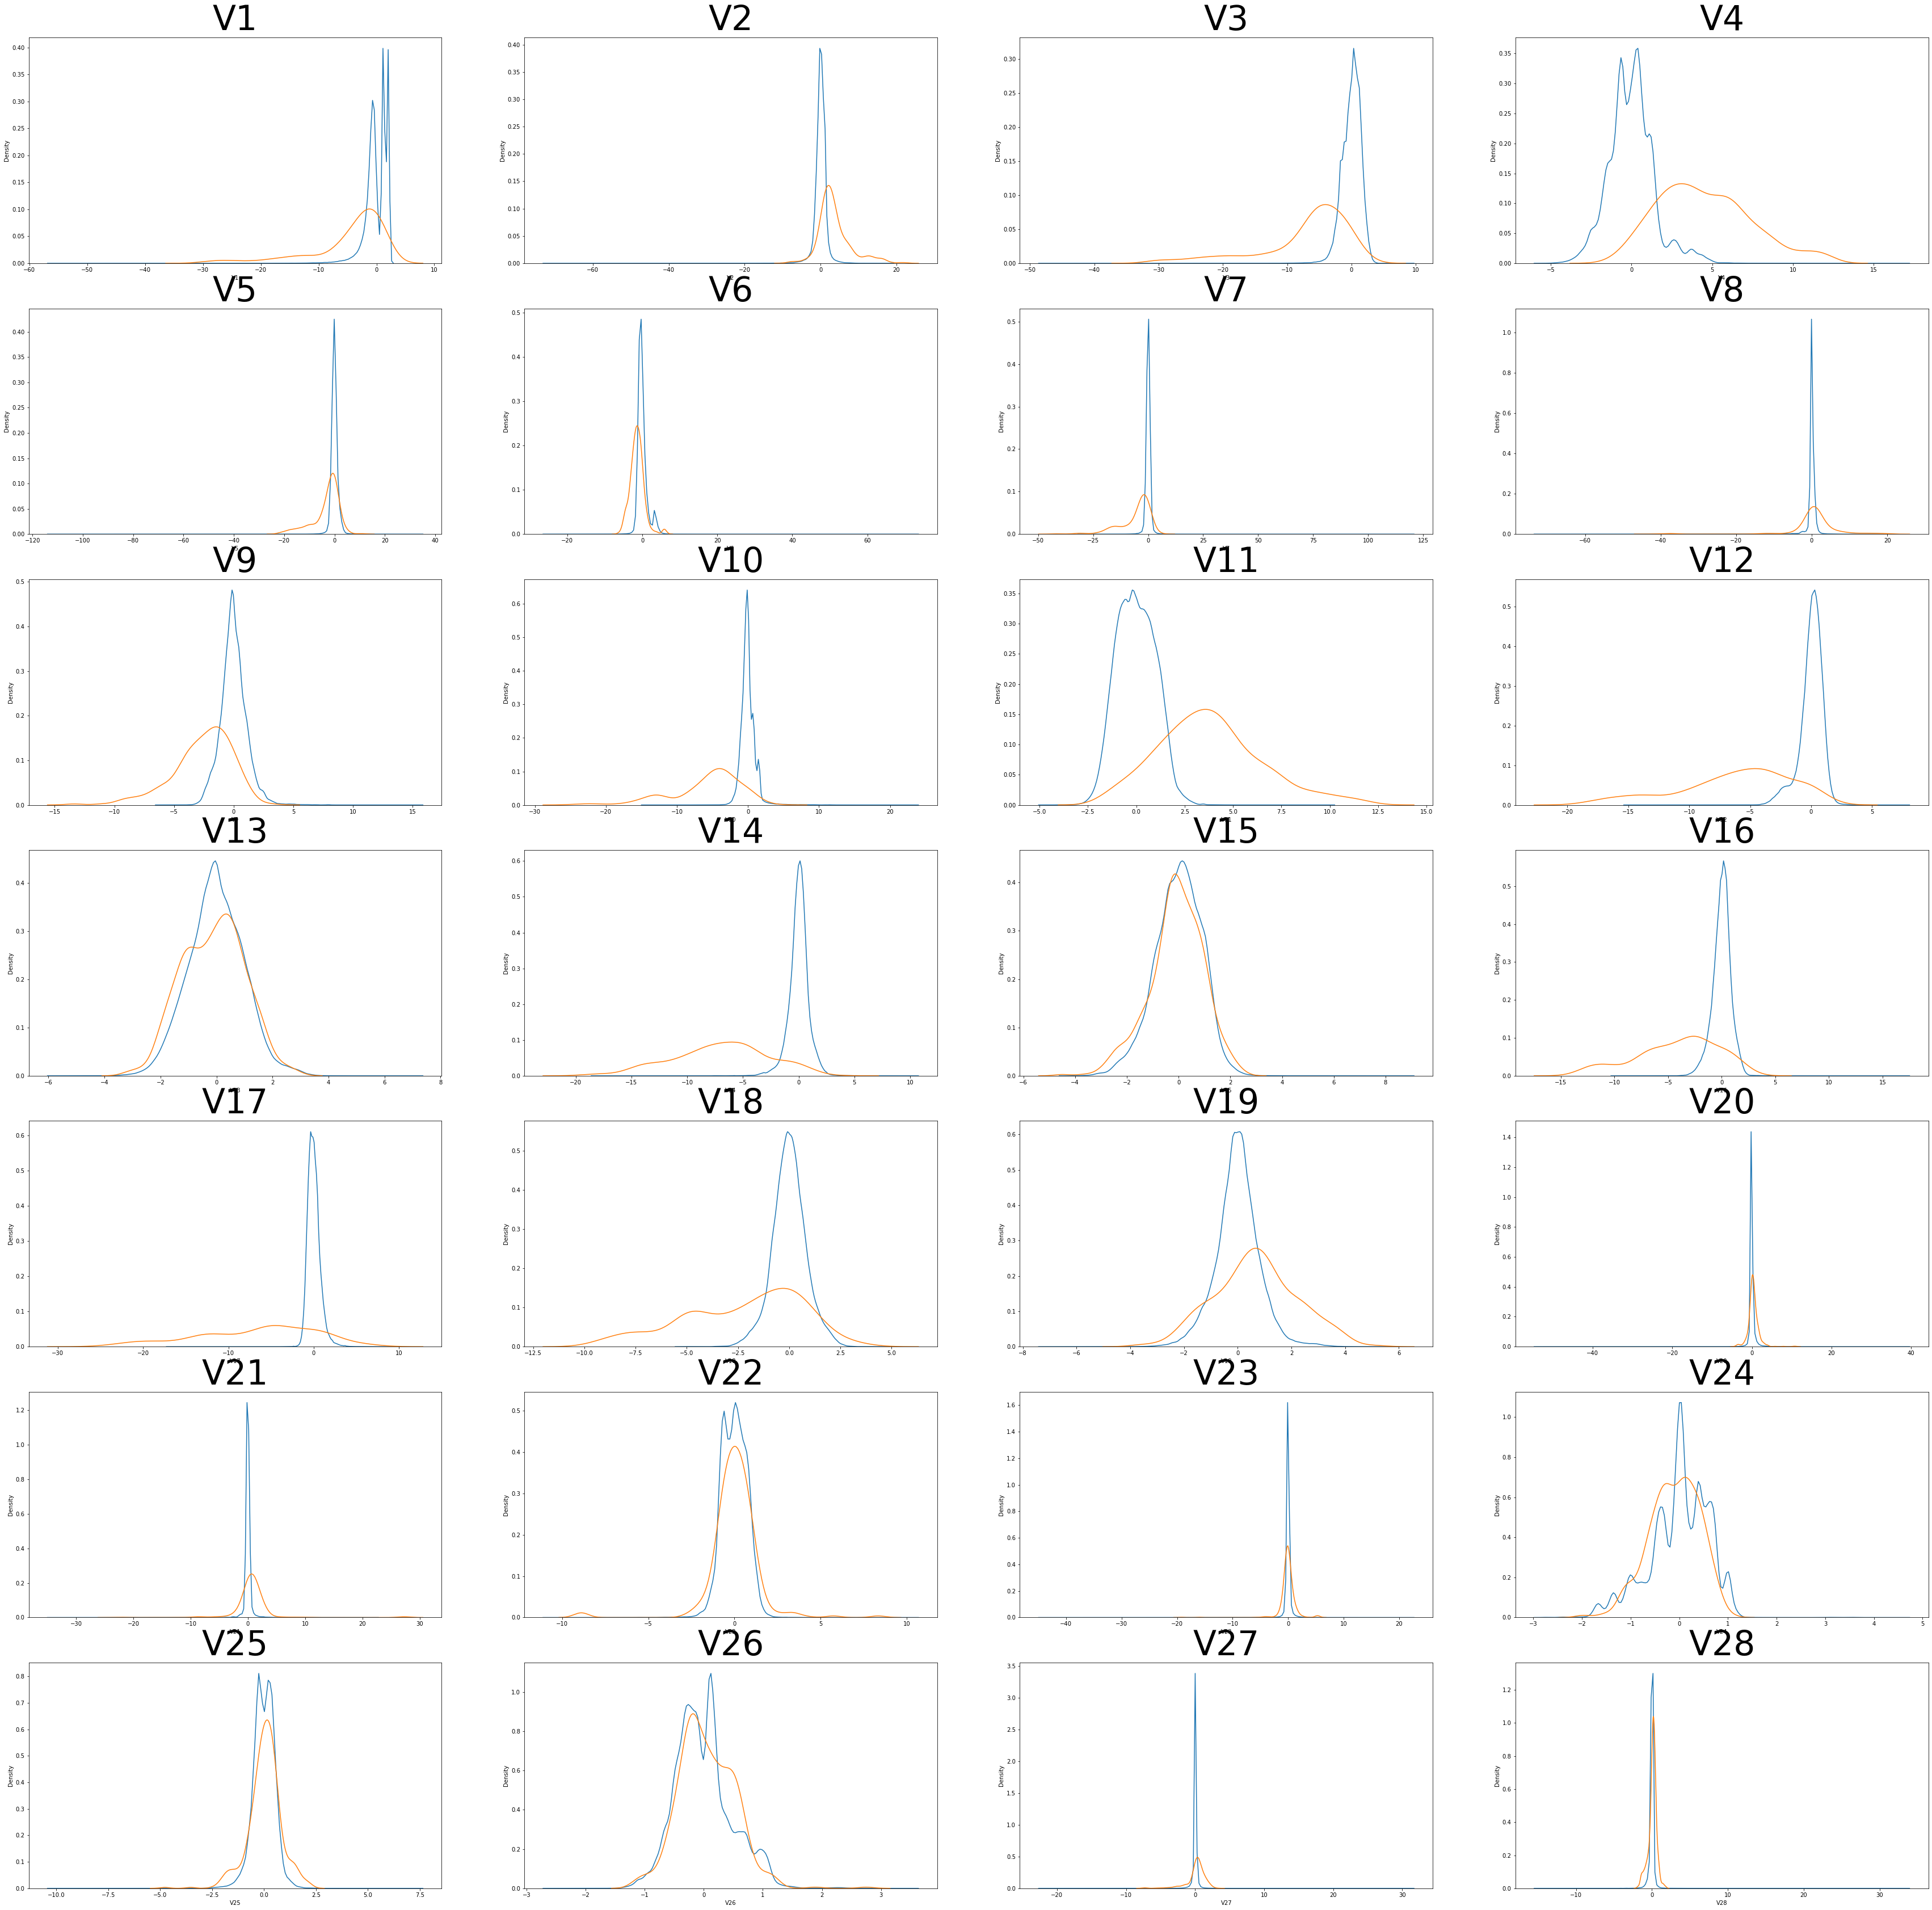

In [17]:
# Comparing density functions. 

features = fraud.columns.drop(["time_scaled","amount_scaled","Class"])
fig, axs = plt.subplots(7,4, figsize=(60,60))

for axis,feature in zip(axs.flat,features):
    sns.kdeplot(no_fraud[feature],ax=axis)
    sns.kdeplot(fraud[feature],ax=axis)
    axis.set_title(feature,fontsize=55)
    
plt.show()
#blue -> no_fraud
#orange -> fraud

**Equaly weighted sample**

An equally weighted sample will be drawn for visualization purposes. Another sample for training purposis will be taken in a later section. 

In [14]:
#creating equally weighted sample
print(fraud.shape) # 492 Fraud cases 
no_fraud_sample = no_fraud.sample(frac=1,random_state=12).iloc[:492] 
fraud_sample = fraud.sample(frac=1,random_state=12).iloc[:492]
#combine samples and shuffel one more time.
equal_sample = pd.concat([no_fraud_sample,fraud_sample], ignore_index=True).sample(frac=1,random_state=4)

(492, 31)


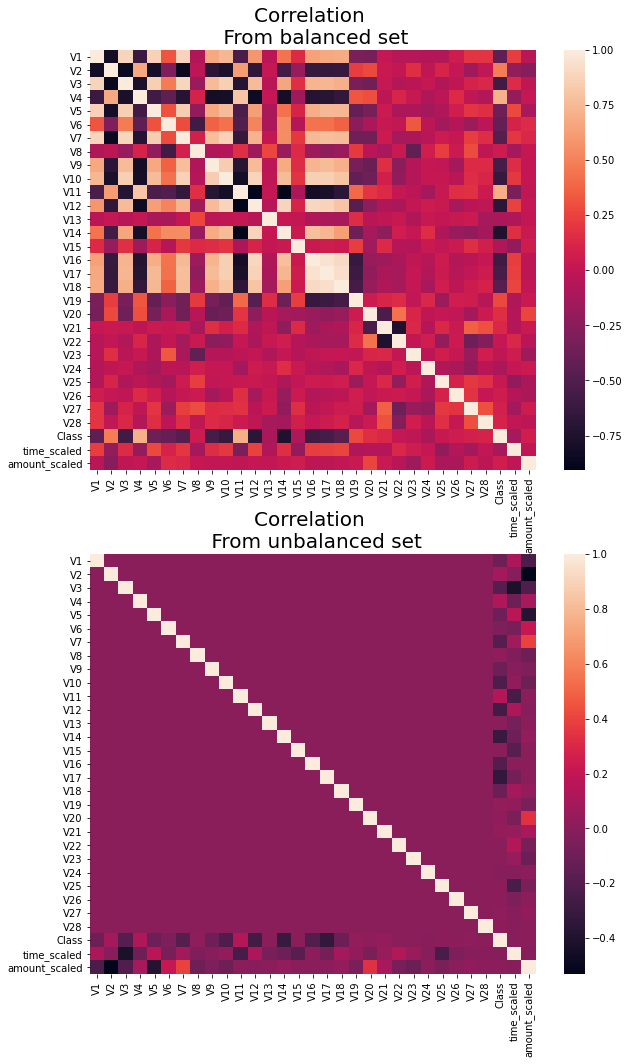

In [15]:
#Vopoint biserial correlation calculated.
corrmat = equal_sample.corr()
f , (ax1, ax2) = plt.subplots(2,1, figsize=(10,17))
sns.heatmap(corrmat,ax=ax1)
ax1.set_title("Correlation \n From balanced set",fontsize=20)

sns.heatmap(data.corr(),ax=ax2)
ax2.set_title("Correlation \n From unbalanced set",fontsize=20)
plt.show()  

In [16]:
#Correlation with label class
#Highest negative correlation with features: V14, V12, V10
#Highest positive correlation with features: V4, V11, V2
corrmat["Class"].sort_values()

V14             -0.749700
V12             -0.686913
V10             -0.628571
V16             -0.592196
V3              -0.573848
V17             -0.555342
V9              -0.555241
V7              -0.482004
V18             -0.469418
V1              -0.432481
V6              -0.401731
V5              -0.374808
time_scaled     -0.124420
V24             -0.106906
V13             -0.104703
V15             -0.072950
V23             -0.009603
V22              0.011378
V25              0.025369
V8               0.051884
V26              0.060057
amount_scaled    0.069891
V27              0.085740
V28              0.100262
V21              0.129620
V20              0.165189
V19              0.270832
V2               0.485948
V11              0.695961
V4               0.712437
Class            1.000000
Name: Class, dtype: float64

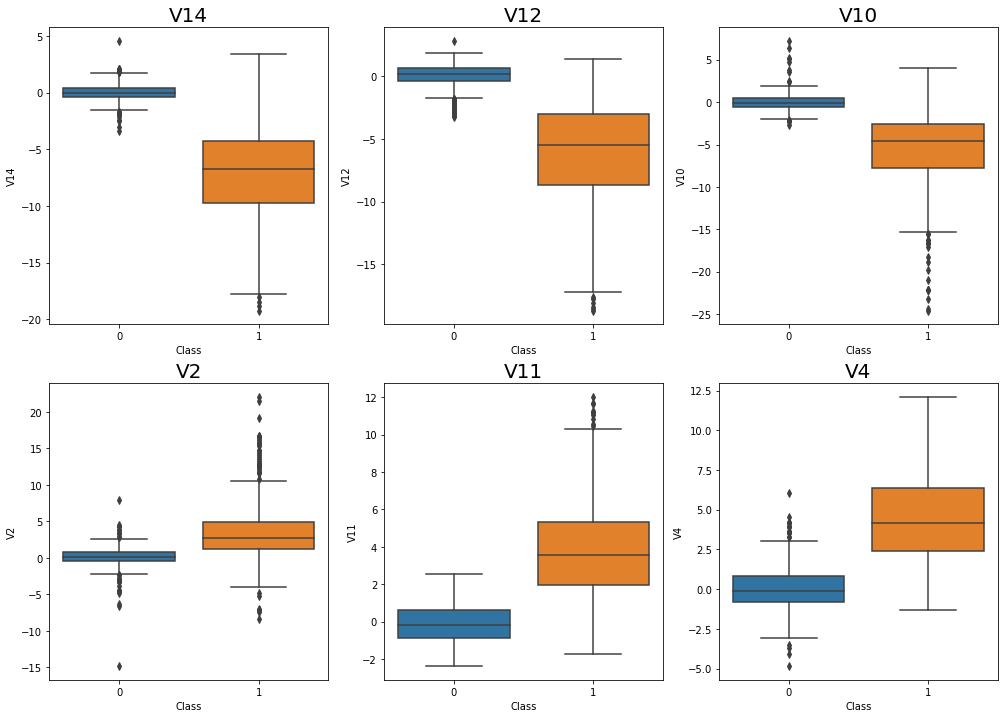

In [17]:
#boxplots of features with highest correlation
fig, axs = plt.subplots(2,3, figsize=(17,12))
highcorr = corrmat["Class"].drop("Class").sort_values().index[[0,1,2,-3,-2,-1]]

for ax, feature in zip(axs.flat,highcorr):
    sns.boxplot(x="Class", y=feature,data=equal_sample, ax= ax)
    ax.set_title(feature,fontsize=20)

We observe some extreme outliers, especially for feature V2,V4 and V10. For now we leave the data as it is, but keep in mind that the present of outliers may bias the result. An alternative approache would be to drop all the obersavtions, which are more than 1.5 times the IQR away form quartile 25 or 75.
The tradeoff here is information loss due to deleted entries versus the risk of biased results.

In [19]:
nofraud_features = no_fraud.drop("Class",axis=1)
fraud_features = fraud.drop("Class",axis=1)

In [20]:
def outlier_detection(df,cols):
    
    outlier_index = []
    
    for col in cols:
        q1 = np.quantile(df[col],0.25)
        q3 = np.quantile(df[col],0.75)
        iqr = q3 - q1
        upper_limit = q3 + 1.5 * iqr
        lower_limit = q1 - 1.5 * iqr
        
        for i, element in enumerate(df[col]):
            if (lower_limit > element) or (upper_limit < element):
                outlier_index.append(i)
    
    outlier_index = pd.Series(outlier_index).drop_duplicates().reset_index(drop=True)
    
    return outlier_index

In [21]:
fraud_outliers = outlier_detection(fraud, ["V14","V12","V10","V2","V11","V4"])
nofraud_outliers = outlier_detection(no_fraud, ["V14","V12","V10","V2","V11","V4"])

print(len(fraud_outliers))
print(len(nofraud_outliers))
#NOT executed
#fraud.drop(index=fraud_outliers, inplace=True)
#no_fraud.drop(index=nofraud_outliers, inplace=True)

#data = pd.concat([fraud,no_fraud])

66
47357


In total, there are over 13,000 outliers only in the six most positive or negative correlated features.
In addtion, almost 10% of the observed fraud cases are marked as outliers. Removing that many entries could lead to severe information loss. Our result are also better, when keeping all observations. Therefore, no observations are removed.

**Cluster Analysis** 

In [22]:
classes = equal_sample.Class
d_reduction_df = equal_sample.drop("Class",axis=1)

pca = PCA(n_components = 2)
fitted_pca = pca.fit_transform(d_reduction_df)

tsne = TSNE(n_components = 2, random_state=1)
fitted_tsne= tsne.fit_transform(d_reduction_df)

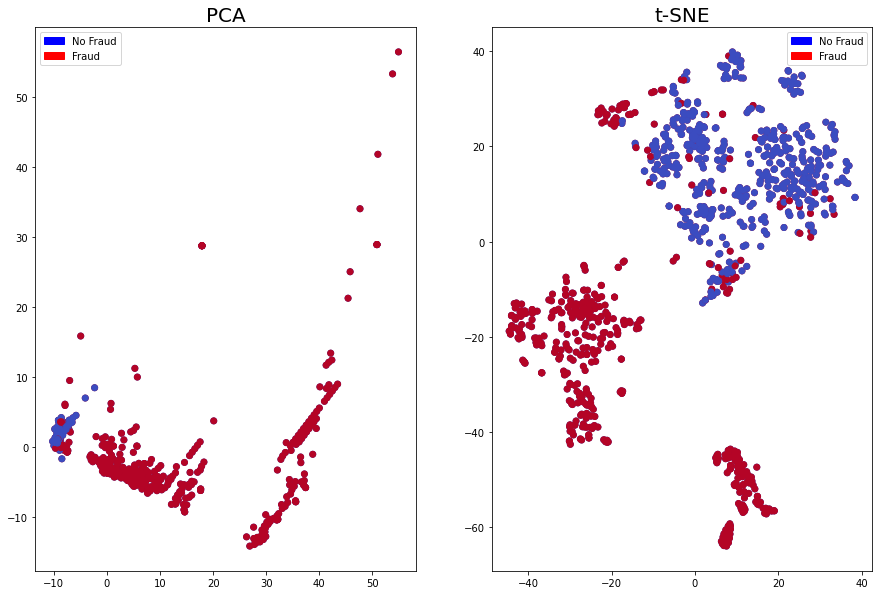

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))

blue = mpatches.Patch(color="Blue", label ="No Fraud")
red = mpatches.Patch(color="Red", label ="Fraud")

ax1.scatter(fitted_pca[:,0],fitted_pca[:,1], c = (classes==0), cmap="coolwarm", label="No Fraud")
ax1.scatter(fitted_pca[:,0],fitted_pca[:,1], c = (classes==1), cmap="coolwarm", label="Fraud")
ax1.legend(handles=[blue,red])
ax1.set_title("PCA", fontsize = 20)

ax2.scatter(fitted_tsne[:,0],fitted_tsne[:,1], c = (classes==0), cmap="coolwarm", label="No Fraud")
ax2.scatter(fitted_tsne[:,0],fitted_tsne[:,1], c = (classes==1), cmap="coolwarm", label="Fraud")
ax2.legend(handles=[blue,red])
ax2.set_title("t-SNE", fontsize = 20)

plt.show()

Above one can see the result of an dimension reduction using a linear and non-linear approache. Both techniques are able to form clusters that seperate the classes decently. Further predictive models are likely to perform well. In the next step, we will apply a nonlinear (Decision Tree, KNN) and a linear (Logistic Regression, Support Vector Maschine) approche to classify a test set.

**Train-Test split**

In most cases the dataset can simply be split in a test and train set, but thats not the case for highly imbalanced data. Many classification techniques will fail to find a way to seperate the classes. The support vector classifier for instances - like other methods - classifies almost every given oberservation as non fraud. 

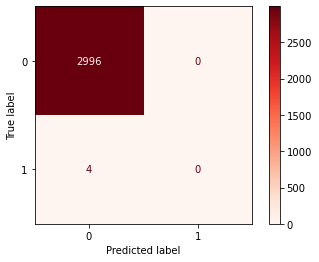

In [21]:
#naive implementation of SVC
svc = LinearSVC(max_iter=10000, C = 0.001)
data_shuffeld = data.sample(frac=1,random_state=13)
svc = svc.fit(data_shuffeld.drop("Class",axis=1)[:20000], data_shuffeld.Class[:20000])
plot_confusion_matrix(svc, data_shuffeld.drop("Class", axis = 1)[20000:23000],
                      data_shuffeld.Class[20000:23000], cmap = plt.cm.Reds)
plt.show()

Even when random state and train size is iterrated, a clear trend emerges: There is rarely a prediction of fraud.The false negative rate can be as high as 0.8.

The goal from now on is the following. Modifie the training strategy in a way that Fraud cases are predicted accurately. Even when that means predicting more flase positive cases. In context, flase postive classification would just have to pass through additional authentication. The consequences of false postive are way more severe as fraud goes by undetected.

**SMOTE**

There are several undersampling or oversampling methods available to deal with imbalanced dataset. In this case, i would like to explore the Synthetic Minority Oversampling Technique (SMOTE). It is - as the name suggests - a oversampling mehtod that not only randomly samples the same observation more than once but baseicly creates new obervations that are similar to other existing ones of a given class. 

In [25]:
oversample = SMOTE(sampling_strategy = 0.3) # sampling_strategy is the ratio of both classes 
X = data_shuffeld.drop("Class",axis=1)
y = data_shuffeld.Class

In [26]:
smote_x, smote_y =  oversample.fit_resample(X,y)
print(smote_y.sum()) # Over 80,000 fraud observation were created syntheticly

85294


One short note on cross-validation with oversampled data: test sets should not be transformed in any way. If oversampling is applied before cross-validating, we are influencing the test sets. Therefore, the folds should be created beforehand and SMOTE only applied on the train folds. The model is than-evaluated on the non transfromed test set.  

Also, on should use stratified cross-validation. Otherwise some folds may contain no observation of the fraud class. By using stratified cross-validation one makes sure that the labels have the same distributions in every fold.

The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class. Therefore, a pipline based on this suggestion is later formed.

In [27]:
#splitting original dataframe in train and train set
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=14)

In [28]:
print("Fraud cases in train set : {}".format(train_y.sum()))
print("Fraud cases in test set : {}".format(test_y.sum()))

Fraud cases in train set : 399
Fraud cases in test set : 93


In [29]:
def report(true_y, pred_y, estimator_name = ""):
    
    confusion = confusion_matrix(true_y, pred_y)
    
    tp = confusion[0,0] # true no fraud
    fp = confusion[1,0] # false no fraud
    tn = confusion[1,1] # true fraud
    fn = confusion[0,1] # false fraud
    
    precision_nofraud = tp / (tp + fp) #Percentage of positive predictions that are truely positve
    precision_fraud = tn / (tn + fn)
    recall_nofraud = tp / (tp + fn) # Percentage of correctly specified postives
    recall_fraud = tn / (tn + fp)
    f1_nofraud = 2 * (precision_nofraud * recall_nofraud)/(precision_nofraud + recall_nofraud)
    f1_fraud = 2 * (precision_fraud * recall_fraud)/(precision_fraud + recall_fraud)
    support_nofraud = tp + fn # number of no fraud cases
    support_fraud = tn + fp
    
    
    
    accuracy = (tp + tn)/(support_fraud + support_nofraud)
    balanced_accuracy = (tp/support_nofraud+tn/support_fraud)/2
    
    report_frame = pd.DataFrame({"Precision": [precision_nofraud,precision_fraud],
                          "Recall": [recall_nofraud, recall_fraud],
                          "f1 score": [f1_nofraud,f1_fraud],
                          "Support": [support_nofraud, support_fraud]
                         }, index = ["No Fraud","Fraud"]) 
    
    report_frame = report_frame.apply(round, args = [2])
    
    print("Classification Report: {}".format(estimator_name))
    print("\n")
    print("Accuracy: {}".format(round(accuracy,2)))
    print("Balanced Accuracy: {}".format(round(balanced_accuracy,2)))
    print("\n")
    print(report_frame)
    
    #display confusion matrix
    fig, ax = plt.subplots(1,1)
    ax.set_title("{} Confusion Matrix \n".format(estimator_name), fontsize = 12, loc="center")
    display = ConfusionMatrixDisplay(confusion, display_labels = ["No Fraud", "Fraud"])
    display.plot(cmap = plt.cm.Reds, ax = ax)
    plt.show()
    print("\n")

Classification Report: Logistic Regression


Accuracy: 0.98
Balanced Accuracy: 0.97


          Precision  Recall  f1 score  Support
No Fraud       1.00    0.98      0.99    56869
Fraud          0.06    0.96      0.12       93


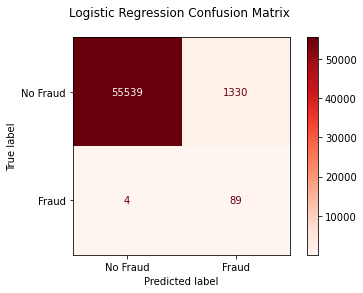



Classification Report: Decision Tree


Accuracy: 0.99
Balanced Accuracy: 0.94


          Precision  Recall  f1 score  Support
No Fraud        1.0    0.99      0.99    56869
Fraud           0.1    0.89      0.18       93


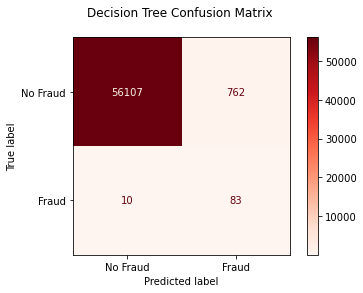



Classification Report: K Nearest Neighbors


Accuracy: 0.99
Balanced Accuracy: 0.96


          Precision  Recall  f1 score  Support
No Fraud       1.00    0.99      1.00    56869
Fraud          0.16    0.94      0.27       93


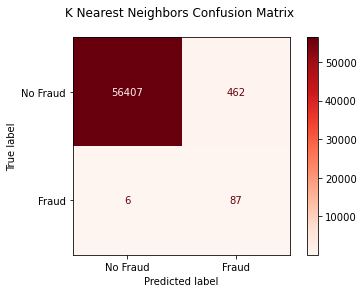



Classification Report: Linear Support Vector Classifier


Accuracy: 0.98
Balanced Accuracy: 0.96


          Precision  Recall  f1 score  Support
No Fraud       1.00    0.98      0.99    56869
Fraud          0.07    0.95      0.14       93


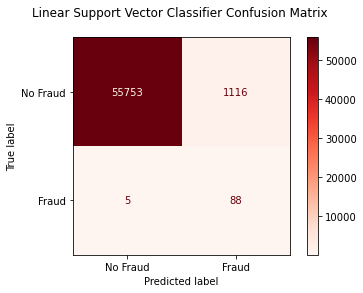

In [55]:
#Five folds with constant proportion of classes
strat_kfold = StratifiedKFold(n_splits = 5)

#Pipline function is used to apply transformations to training folds before CV

create_pipe = lambda estimator,strategy: Pipeline(
    [("SMOTE",SMOTE(sampling_strategy = strategy, random_state=20)),
     ("UnderSample",RandomUnderSampler(random_state=10)),
     ("model", estimator)])

#Logistic Regression

pipe = create_pipe(LogisticRegression(max_iter=300),0.3)
lr_params= {"model__C":[0.001 * 10 ** i for i in range(0,7,1)]}
lr_rcv = RandomizedSearchCV(pipe,lr_params,cv = strat_kfold, n_iter=7).fit(train_x,train_y)
lr = lr_rcv.best_estimator_[2]
lr_predictions = lr.predict(test_x)

report(test_y,lr_predictions,"Logistic Regression")

# Decision Tree Clasifier

pipe = create_pipe(DecisionTreeClassifier(),0.3)
dt_params = {"model__criterion": ["gini","entropy"],
             "model__splitter": ["best", "random"],
             "model__max_depth": [6,7,8]}
dt_rcv = RandomizedSearchCV(pipe,dt_params,cv = strat_kfold, n_iter=10).fit(train_x,train_y)
dt = dt_rcv.best_estimator_[2]
dt_predictions = dt.predict(test_x)

report(test_y,dt_predictions,"Decision Tree")

# KNN
# Due to performance issues standard KNN is implemendet without CV or Grid Search

pipe = create_pipe(KNeighborsClassifier(n_neighbors = 7), 0.3)
knn = pipe.fit(train_x,train_y)
knn_predictions = knn.predict(test_x)

report(test_y,knn_predictions,"K Nearest Neighbors")

# Linear SVC

pipe=create_pipe(LinearSVC(),0.3)
svc_params = {
    "model__C": [0.00001,0.0001] # for values greater than 0.0001 not converging
}

svc_rcv = RandomizedSearchCV(pipe,svc_params,cv = strat_kfold, n_iter=2).fit(train_x,train_y)
svc = svc_rcv.best_estimator_[2]
svc_predictions = svc.predict(test_x)
report(test_y,svc_predictions,"Linear Support Vector Classifier")

In [54]:
# Parameters of best estimators
print(lr)
print(dt)
print(knn[2])
print(svc)

LogisticRegression(C=0.001, max_iter=300)
DecisionTreeClassifier(max_depth=8, splitter='random')
KNeighborsClassifier(n_neighbors=7)
LinearSVC(C=0.0001)


**Conclusion**

If the consequences are not serious, methods can be applied that falsely identify many cases as fraud. This is given in this scenario, since it only leads to further authenmtification measures in the first place. Given this assumption, logistic regression produces the best results. 96% of all fraud cases are actually detected by it. The best existing recall value. The balanced accuracy is also good with 97%   . 

An alternative is the KNN. The recall value drops to 94%. However, the false fraud estimates are also halved.

Depending on the consequence of incorrect fraud predictions, KNN or logistic regression is the recommended method.
